### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Chargement des données

In [2]:
interactions_test = pd.read_csv('data/interactions_test.csv')
interactions_train = pd.read_csv('data/interactions_train.csv')
RAW_interactions = pd.read_csv('data/RAW_interactions.csv')
RAW_recipes = pd.read_csv('data/RAW_recipes.csv')

### Exploration des données

#### Affichage du contenu des fichiers

In [3]:
print(f"interactions_train {interactions_train.shape}  | keys : {interactions_train.keys().to_list()}")
print(interactions_train.head(5))

interactions_train (698901, 6)  | keys : ['user_id', 'recipe_id', 'date', 'rating', 'u', 'i']
   user_id  recipe_id        date  rating      u       i
0     2046       4684  2000-02-25     5.0  22095   44367
1     2046        517  2000-02-25     5.0  22095   87844
2     1773       7435  2000-03-13     5.0  24732  138181
3     1773        278  2000-03-13     4.0  24732   93054
4     2046       3431  2000-04-07     5.0  22095  101723


In [4]:
print(f"interactions_test  {interactions_test.shape}   | keys : {interactions_test.keys().to_list()}")
print(interactions_test.head(5))

interactions_test  (12455, 6)   | keys : ['user_id', 'recipe_id', 'date', 'rating', 'u', 'i']
   user_id  recipe_id        date  rating   u       i
0     8937      44551  2005-12-23     4.0   2  173538
1    56680     126118  2006-10-07     4.0  16  177847
2   349752     219596  2008-04-12     0.0  26   89896
3   628951      82783  2007-11-13     2.0  45  172637
4    92816     435013  2013-07-31     3.0  52  177935


In [5]:
print(f"RAW_interactions   {RAW_interactions.shape} | keys : {RAW_interactions.keys().to_list()}")
print(RAW_interactions.head(5))

RAW_interactions   (1132367, 5) | keys : ['user_id', 'recipe_id', 'date', 'rating', 'review']
   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  


In [6]:
print(f"RAW_recipes        {RAW_recipes.shape} | keys : {RAW_recipes.keys().to_list()}")
print(RAW_recipes.head(1))

RAW_recipes        (231637, 12) | keys : ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   

   contributor_id   submitted  \
0           47892  2005-09-16   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   

                               nutrition  n_steps  \
0  [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   

                                         ingredients  n_ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...              7  


#### Exploration des notes

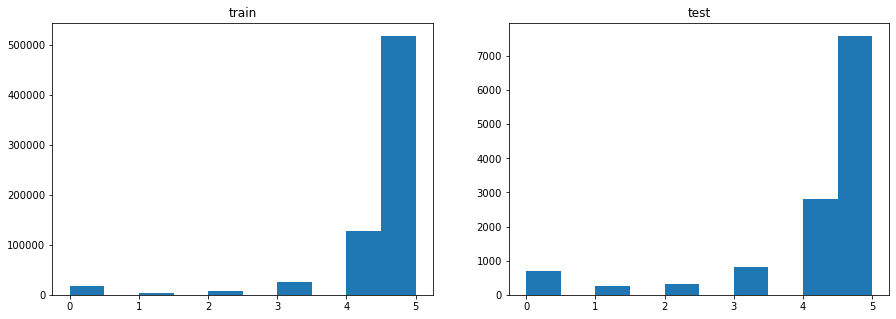

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(interactions_train.rating)
plt.title("train")
plt.subplot(1,2,2)
plt.hist(interactions_test.rating)
plt.title("test")
plt.show()

Isolation des notes nulles

In [8]:
RAW_interactions.loc[RAW_interactions.rating ==0]["review"]

6          Just an observation, so I will not rate.  I fo...
12         Made my own buttermilk w/ vinegar and milk.  U...
23         This is a very good recipe.  We also want to c...
39                              i made it and it was amazing
56         I used half cream and half 1% milk, added anot...
                                 ...                        
1132318    Delicious ! I tweeked the recipe a bit>>substi...
1132323    Just added this mix to a homemade beef &amp; s...
1132325    Would this make a good hamburger patty seasoning?
1132361    I am not going to rate this because I did have...
1132362    Another approach is to start making sauce with...
Name: review, Length: 60847, dtype: object

Les notes nulles correspondent dans la plupart des cas à des commentaires positifs, on les supprime donc.

### Elimination des notes nulles et création du label "positif"

In [9]:
RAW_interactions_clean = RAW_interactions.drop(RAW_interactions[RAW_interactions.rating == 0].index).fillna('')

In [10]:
RAW_interactions_clean["positive"] = RAW_interactions_clean.rating.apply(lambda x: x > 3)

### Train test split

In [11]:
from sklearn.model_selection import train_test_split

max_data = 500

train_clean, test_clean = train_test_split(RAW_interactions_clean.iloc[:max_data], test_size=0.2)

## TFIDF basique

### Calcul de la matrice TFIDF et de la distance entre les avis

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features = 100)
tfidf_matrix = tfidf.fit_transform(train_clean['review'])

In [29]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix, tfidf_matrix)

### Calcul des avis proches et affichage de leur note

In [32]:
def get_closest(idx, sim_matrix, num_neighbors=5):
  print(f'original: ({train_clean.iloc[idx]["rating"]}/5) {train_clean.iloc[idx]["review"]}\n')
  closest = sim_matrix[idx].argsort()[1:num_neighbors+1]
  for i in range(0,num_neighbors):
    print(f'{i+1}/ ({train_clean.iloc[closest[i]]["rating"]}/5) {train_clean.iloc[closest[i]]["review"]}\n')

In [33]:
get_closest(1, cosine_sim, num_neighbors=3)

original: (3/5) I'm sorry I couldn't give this a higher rating ... I appreciated the fact that this could be made so that it's virtually nonfat.  But I thought there was too much gelatin in it -- in fact, when I tried to pour the base mixture into the ice cream freezer, it had already solidified into a gelatinous, mass.  (I used Trader Joe's plain nonfat yogurt).  I'll keep looking for my platonic ideal of vanilla frozen yogurt -- but thanks for posting this!

1/ (5/5) i have had no problem with the gelatin, as another user has posted.  I have only had good results, the most fluffy, light, dreamy, creamy frozen yogurt I have ever made. DEFINITELY the best vanilla frozen yogurt I have had.

2/ (5/5) I halved this (except the vanilla- oops!) for my Cuisinart icecream maker as a couple others did-- great stuff!  We are excited to try it tomorrow after it's ripened too because the super-frozen parts left in the bowl were the best we thought.  We didn't find we needed to chill the mixture a

## TFIDF avec Stemming

### Calcul de la matrice TFIDF

In [39]:
from nltk import word_tokenize          
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
# Download stopwords list

stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()
token_stop = tokenizer(' '.join(stop_words))

[nltk_data] Downloading package punkt to /home/n7student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/n7student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# Create TF-idf model
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=100)

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(train_clean['review'])

In [120]:
np.array([w for w in tokenizer(train_clean.iloc[0]['review']) if not w.lower() in token_stop])

array(['favorit', 'meatloaf', 'start', 'buy', 'half', 'lamb', 'everi',
       'year', '&', '#', '039', 'sure', 'ground', 'lamb', 'went',
       'search', 'yummi', 'thing', 'make', 'made', 'sever', 'time',
       'alway', 'delight', 'share', 'super', 'easi', 'oh', 'tasti',
       'thank', 'share'], dtype='<U8')

In [123]:
tfidf.get_feature_names()

['!',
 '#',
 '&',
 "'m",
 '(',
 ')',
 '*',
 '-',
 '...',
 '039',
 '1',
 '1/2',
 '2',
 '5',
 'ad',
 'add',
 'also',
 'bake',
 'bean',
 'bit',
 'butter',
 'cake',
 'came',
 'chang',
 'chees',
 'chicken',
 'chocol',
 'chop',
 'cook',
 'cooki',
 'cream',
 'crust',
 'cup',
 'cut',
 'definit',
 'delici',
 'dinner',
 'easi',
 'enjoy',
 'even',
 'extra',
 'flavor',
 'follow',
 'fresh',
 'get',
 'give',
 'good',
 'great',
 'half',
 'ingredi',
 'instead',
 'light',
 'like',
 'littl',
 'lot',
 'love',
 'made',
 'make',
 'mix',
 'much',
 'next',
 'nice',
 'old',
 'one',
 'onion',
 'pan',
 'pepper',
 'perfect',
 'post',
 'put',
 'quick',
 'realli',
 'recip',
 'review',
 'sauc',
 'serv',
 'share',
 'soup',
 'star',
 'sugar',
 'sure',
 'sweet',
 'tast',
 'tasti',
 'thank',
 'thing',
 'think',
 'time',
 'tomato',
 'top',
 'tri',
 'turn',
 'use',
 'vanilla',
 'way',
 'well',
 'wonder',
 'work',
 'year',
 'yogurt']

In [110]:
tfidf.transform([train_clean.iloc[0]['review']]).toarray()

array([[0.        , 0.26603185, 0.24429945, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.30965623,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.19831375, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.28629625, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1412114 , 0.15107245, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [83]:
idx_imp_words = np.argsort(-tfidf_matrix.toarray(), axis=1)

In [93]:
np.array(tokenizer(train_clean.iloc[0]['review']))

array(['this', 'is', 'my', 'favorit', 'meatloaf', 'we', 'start', 'buy',
       'half', 'a', 'lamb', 'everi', 'year', 'i', 'wasn', '&', '#', '039',
       't', 'sure', 'what', 'to', 'do', 'with', 'the', 'ground', 'lamb',
       'so', 'off', 'i', 'went', 'to', 'search', 'out', 'yummi', 'thing',
       'to', 'make', 'i', 'have', 'made', 'this', 'sever', 'time', 'now',
       'and', 'it', 'alway', 'is', 'a', 'delight', 'for', 'those', 'i',
       'share', 'it', 'with', 'super', 'easi', 'but', 'oh', 'so', 'tasti',
       'thank', 'you', 'for', 'share', 'this'], dtype='<U8')

In [124]:
tfidf_matrix.toarray()[:,1]

array([0.26603185, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.41109055, 0.        , 0.        ,
       0.        , 0.        , 0.46166504, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.39722564,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.39425804,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [85]:
idx_imp_words[0]

array([76,  9, 48, 85, 98, 80,  1, 83,  2, 37, 87, 57, 56, 84, 60, 69, 68,
       67, 66, 65, 55, 64, 58, 63, 70, 62, 61, 59, 71,  0, 73, 97, 96, 95,
       94, 93, 92, 91, 90, 89, 88, 86, 82, 81, 79, 78, 77, 54, 75, 74, 72,
       53, 49, 51, 23, 22, 21, 20, 19, 18, 17, 16, 15, 24, 14, 12, 11, 10,
        8,  7,  6,  5,  4,  3, 13, 52, 25, 27, 50, 47, 46, 45, 44, 43, 42,
       41, 40, 26, 39, 36, 35, 34, 33, 32, 31, 30, 29, 28, 38, 99])

In [81]:
len(tokenizer(train_clean['review'].values[0]))

68

In [79]:
for i in range(5):#train_clean.shape[0]):
    print(idx_imp_words[i])
    print(np.array(tokenizer(train_clean['review'].values[i]))[idx_imp_words[i]])

[309 278 190 214 379]


IndexError: index 309 is out of bounds for axis 0 with size 68